In [4]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms



# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *
from apmeter import *
from train_valid_split import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [5]:
def plot_loss(trn_hist, val_hist, loss_acc):
    plt.plot(trn_hist, label='Training ' + loss_acc)
    plt.plot(val_hist, label='Validation ' + loss_acc)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(loss_acc)
    plt.show()

In [ ]:
def freeze_bn(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

In [6]:
use_gpu = True
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if (cuda_available and use_gpu) else "cpu")

In [7]:
DATA_DIR = "F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/willow_PNG/"

sz = 224
batch_size = 16

In [8]:
os.listdir(DATA_DIR)

['test', 'train']

In [13]:
trn_dir = f'{DATA_DIR}train'
#val_dir = f'{DATA_DIR}valid'

In [14]:
os.listdir(trn_dir)

['InteractingWithComputer',
 'Photographing',
 'PlayingMusic',
 'RidingBike',
 'RidingHorse',
 'Running',
 'Walking']

In [15]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.png')
trn_fnames[:5]

['F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/willow_PNG/train\\InteractingWithComputer\\action0002.png',
 'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/willow_PNG/train\\InteractingWithComputer\\action0004.png',
 'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/willow_PNG/train\\InteractingWithComputer\\action0005.png',
 'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/willow_PNG/train\\InteractingWithComputer\\action0006.png',
 'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/willow_PNG/train\\InteractingWithComputer\\action0007.png']

In [16]:
# LOAD DATA
train_ds = datasets.ImageFolder(trn_dir)

In [17]:
train_ds.classes

['InteractingWithComputer',
 'Photographing',
 'PlayingMusic',
 'RidingBike',
 'RidingHorse',
 'Running',
 'Walking']

In [18]:
train_ds.class_to_idx

{'InteractingWithComputer': 0,
 'Photographing': 1,
 'PlayingMusic': 2,
 'RidingBike': 3,
 'RidingHorse': 4,
 'Running': 5,
 'Walking': 6}

In [19]:
train_ds.root

'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/willow_PNG/train'

In [27]:

# Data augmentation and normalization for training 
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
#valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)


train_ds, valid_ds = train_valid_split(train_ds, 10)

class_names = train_ds.mother.classes

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

Train size: 387
Valid size: 42 (0.10)


In [21]:
# dataloader
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=4)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=4)

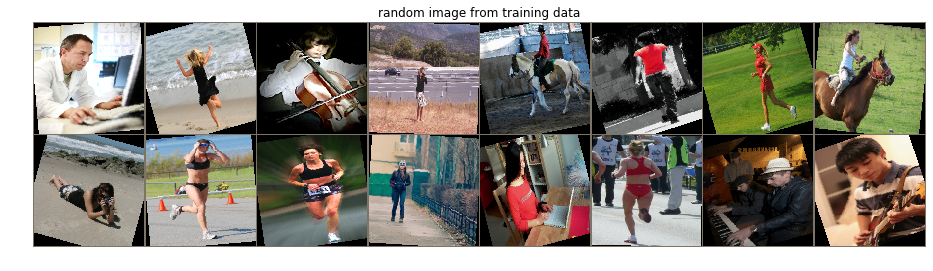

In [22]:
inputs,targets =  next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='random image from training data')

In [23]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# load pre-trained ResNet50
model = load_pretrained_resnet50(model_path=None, num_classes=7)
model.apply(freeze_bn)
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0002)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)

model = model.to(device)
criterion = criterion.to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [24]:
# training
model, trn_loss_hist, val_loss_hist, trn_acc_hist, val_acc_hist = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------
  train Loss: 1.95371 Acc: 0.17313
  valid Loss: 1.86257 Acc: 0.28571

Epoch 2/20
----------
  train Loss: 1.78855 Acc: 0.33333
  valid Loss: 1.73388 Acc: 0.47619

Epoch 3/20
----------
  train Loss: 1.63683 Acc: 0.54264
  valid Loss: 1.57256 Acc: 0.59524

Epoch 4/20
----------
  train Loss: 1.51546 Acc: 0.63307
  valid Loss: 1.49339 Acc: 0.69048

Epoch 5/20
----------
  train Loss: 1.39368 Acc: 0.69509
  valid Loss: 1.42445 Acc: 0.69048

Epoch 6/20
----------
  train Loss: 1.26204 Acc: 0.76486
  valid Loss: 1.37194 Acc: 0.59524

Epoch 7/20
----------
  train Loss: 1.19033 Acc: 0.75452
  valid Loss: 1.24315 Acc: 0.66667

Epoch 8/20
----------
  train Loss: 1.11988 Acc: 0.78553
  valid Loss: 1.25875 Acc: 0.59524

Epoch 9/20
----------
  train Loss: 1.08641 Acc: 0.77778
  valid Loss: 1.20216 Acc: 0.71429

Epoch 10/20
----------
  train Loss: 1.00828 Acc: 0.82171
  valid Loss: 1.07448 Acc: 0.73810

Epoch 11/20
----------
  train Loss: 0.97509 Acc: 0.79070
  valid Los

In [ ]:
loss_acc = 'Loss'
plot_loss(trn_loss_hist, val_loss_hist, loss_acc)

In [ ]:
loss_acc = 'Accuracy'
plot_loss(trn_acc_hist, val_acc_hist, loss_acc)

In [ ]:
for param in model.parameters():
    param.require_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
model, trn_loss_hist1, val_loss_hist1, trn_acc_hist1, val_acc_hist1 = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=10)

In [ ]:
trn_loss_hist.extend(trn_loss_hist1)
val_loss_hist.extend(val_loss_hist1)
trn_acc_hist.extend(trn_acc_hist1)
val_acc_hist.extend(val_acc_hist1)

In [ ]:
loss_acc = 'Loss'
plot_loss(trn_loss_hist, val_loss_hist, loss_acc)

In [ ]:
loss_acc = 'Accuracy'
plot_loss(trn_acc_hist, val_acc_hist, loss_acc)

In [ ]:
# acuracy on validation data

def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [ ]:
# mAP
m = torch.nn.Softmax(dim=1)
def calculate_model_mAP(model, dataloader):
    mAP = APMeter()
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        outputs = m(outputs)
        targets.resize_(targets.size(0), 1)
        targets = Variable(targets)
        
        one_hot = torch.cuda.FloatTensor(targets.size(0), outputs.size(1)).zero_()
        one_hot.scatter_(1, targets.data, 1)
        one_hot = Variable(one_hot)
        mAP.add(outputs,one_hot)

        #print(outputs.data)
    
    for i, value in enumerate(mAP.value()):
        print(train_ds.classes[i], ' AP: {:.2f}'.format(100. * value))
    print('mAP: {:.2f}'.format(100. * mAP.value().sum() / mAP.value().size(0)))

In [ ]:
evaluate_model(model, valid_dl)

In [ ]:
evaluate_model(model, train_dl)

In [ ]:
visualize_model(model, train_dl)

In [ ]:
visualize_model(model, valid_dl)

In [ ]:
plot_errors(model, train_dl)

In [ ]:
# confusion matrix
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(12,12 ))

In [ ]:
# Look at the sizes of the images

fnames = glob.glob(f'{trn_dir}/*/*.png')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [ ]:
visualize_model(model, valid_dl, num_images=6)

In [ ]:
plot_errors(model, valid_dl)

In [ ]:
### testing

class_names = train_ds.classes
test_dir = f'{DATA_DIR}\\test'
test_ds = datasets.ImageFolder(test_dir,valid_transforms)
len(test_ds)

In [ ]:
### dataloder

test_dl =  torch.utils.data.DataLoader(test_ds,batch_size= batch_size, num_workers=4)

In [ ]:
pred_class_names, y = predict_class_names(model, test_dl, class_names)

test_fnames= glob.glob(f'{test_dir}/*/*.png')
len(test_fnames), test_fnames [:5]

In [ ]:
test_fnames_len= len(test_fnames)
for i in range(test_fnames_len):
    test_fnames[i] = os.path.basename(test_fnames[i])
    
    len(test_fnames), test_fnames[:5]

In [ ]:
pred_result = np.stack([test_fnames, pred_class_names], axis=1)
len(pred_result), pred_result

In [ ]:
evaluate_model(model, test_dl)

In [ ]:
calculate_model_mAP(model, test_dl)

In [ ]:
plot_errors(model, test_dl)

In [ ]:
# confusion matrix
y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(12,12 ))